In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.plot import plot_missing_value
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model,load_model
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import random_search_params as rsp

from xgboost import XGBRegressor

In [17]:
df = pd.read_csv('le.csv')
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


# Filter Data

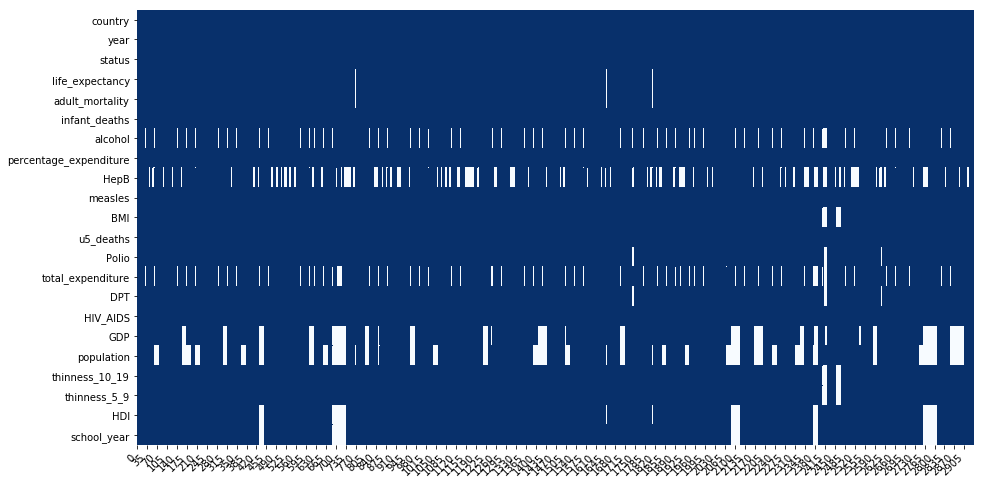

In [3]:
plot_missing_value(df)

In [4]:
#karena kita akan menggunakan metode supervised learning, maka kita harus menghilangkan target yang kosong.
#target kita adalah life_expectancy, jadi harus di drop baris terlebih dahulu.
#kenapa dengan metode supervised learning kita harus drop baris yang kosong?
#karena supervised learning membutuhkan label dari target untuk diprediksi

In [5]:
df = df[~df.life_expectancy.isna()]

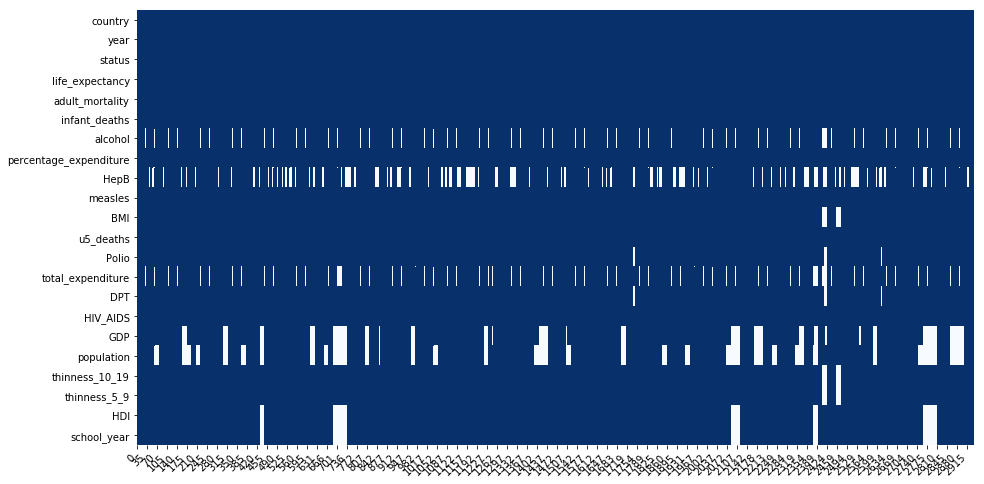

In [6]:
plot_missing_value(df) #kolom target sudah rapih.

# Penyebab Tertinggi Penurunan Kualitas Hidup

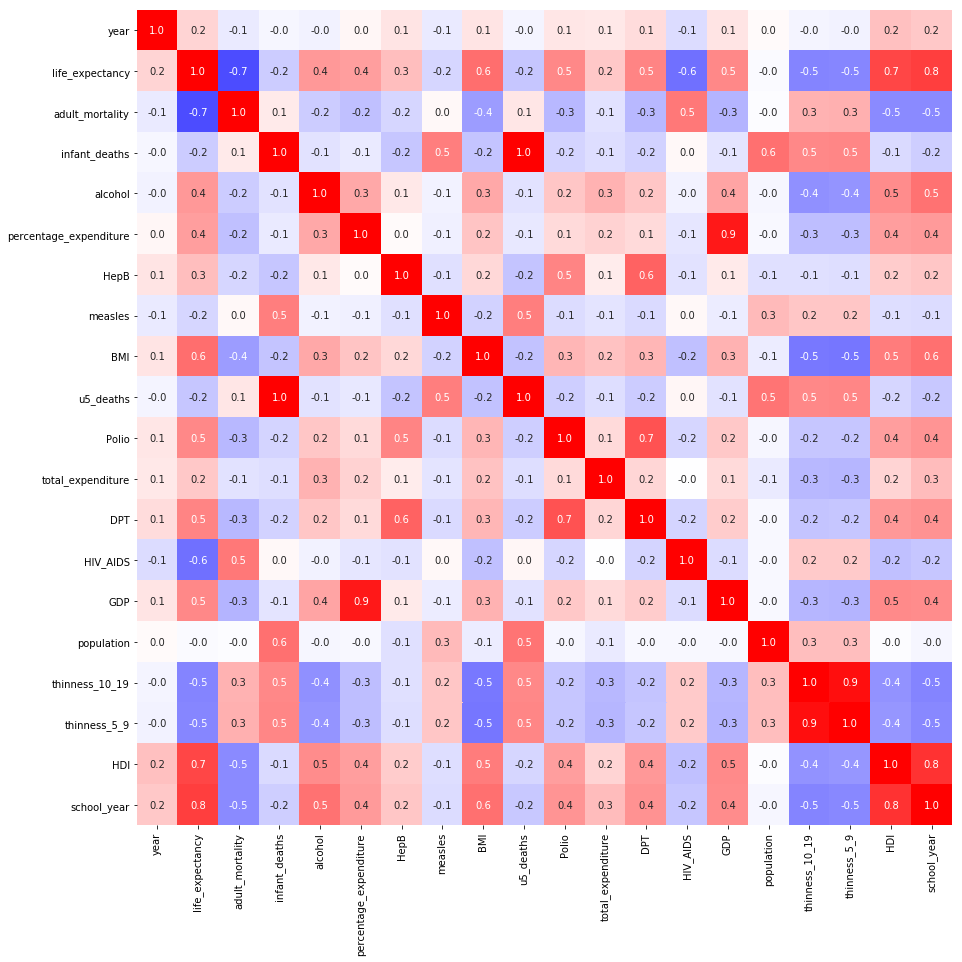

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cmap = 'bwr', cbar=False, vmin = -1, vmax = 1, annot=True, square=True, fmt='.1f')

Jika Nilainya Minus, maka kolom tersebut berbanding terbalik dengan kolom yang berkorelasi. pada gambar diatas, kolom dengan nilai < -0.5 dan > 0.5 merupakan kolom yang berkorelasi dengan kolom lainnya.

sehingga bisa disimpulkan bahwa angka harapan hidup yang baik pasti memiliki angka adult_morality yang rendah dan HIV_AIDS yang rendah, serta memiliki nilai BMI, HDI, dan School_year yang tinggi. 

oleh karena itu, kolom yang berpengaruh pada life_expectancy adalah adult_morality, HIV_AIDS, BMI, HDI, dah School_year.

# Negara Maju vs Negara Berkembang


Dari CIA Factbook bersumber: https://id.wikipedia.org/wiki/Daftar_negara_menurut_angka_harapan_hidup

Angka harapan hidup bisa dibilang rendah jika nilainya kurang dari 65 tahun

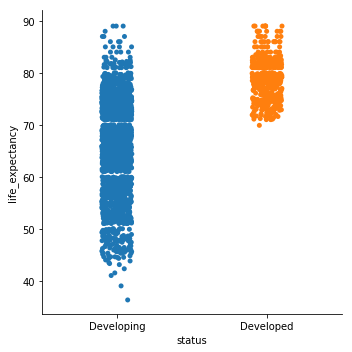

In [35]:
sns.catplot("status", "life_expectancy", data = df)

Dari data diatas bisa disimpulkan bahwa semua negara maju memiliki angka harapan hidup diatas ambang normal( yaitu 65) tetapi jika suatu negara memiliki angka harapan hidup diatas 65 belum tentu negara tersebut merupakan negara maju. 

oleh karena itu untuk menjadi negara maju, suatu negara tidak hanya dinilai dari angka harapan hidup masyarakatnya saja. ada faktor lainnya

# Angka Harapan Hidup Setiap Benua

In [36]:
a = df[df["year"] == 2015].sort_values("life_expectancy", ascending = False)
a.head(n=15)

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
2345,Slovenia,2015,Developed,88.0,74.0,0,NaN,0.0,NaN,18,...,95.0,NaN,95.0,0.1,2729.86383,263531.0,1.4,1.3,0.888,17.3
737,Denmark,2015,Developed,86.0,71.0,0,NaN,0.0,NaN,9,...,93.0,NaN,93.0,0.1,5314.64416,5683483.0,1.1,0.9,0.923,19.2
673,Cyprus,2015,Developed,85.0,52.0,0,NaN,0.0,97.0,0,...,97.0,NaN,97.0,0.1,2375.11270,116985.0,1.0,1.0,0.854,14.3
544,Chile,2015,Developing,85.0,82.0,2,NaN,0.0,97.0,9,...,96.0,NaN,96.0,0.1,13653.22640,17762681.0,0.8,0.8,0.845,16.3
1314,Japan,2015,Developed,83.7,55.0,2,NaN,0.0,NaN,35,...,99.0,NaN,96.0,0.1,34474.13736,127141.0,2.1,1.8,0.902,15.3
2521,Switzerland,2015,Developed,83.4,49.0,0,NaN,0.0,NaN,35,...,97.0,NaN,97.0,0.1,8989.84240,8282396.0,0.4,0.3,0.938,16.0
2313,Singapore,2015,Developed,83.1,55.0,0,1.79,0.0,96.0,0,...,96.0,NaN,96.0,0.1,53629.73746,NaN,2.2,2.2,0.924,15.4
2425,Spain,2015,Developed,82.8,56.0,1,NaN,0.0,97.0,115,...,97.0,NaN,97.0,0.1,25683.84565,46447697.0,0.6,0.5,0.882,17.7
112,Australia,2015,Developed,82.8,59.0,1,NaN,0.0,93.0,74,...,93.0,NaN,93.0,0.1,56554.38760,23789338.0,0.6,0.6,0.937,20.4
1282,Italy,2015,Developed,82.7,56.0,1,NaN,0.0,93.0,159,...,93.0,NaN,93.0,0.1,349.14755,673582.0,0.6,0.6,0.881,16.3



Pada tahun 2015 (saya menggunakan 1 sample saja yaitu tahun 2015, karena terlalu banyak ada data dari 2000-2015) 15 negara dengan life_expectancy terbesar dominan dimiliki oleh negara pada benua eropa dengan 7 negara, yang kedua adalah benua asia dengan 6 negara, yang ketiga adalah benua amerika dan australia dengan masing-masing 1 negara. dari data ini, benua afrika merupakan benua dengan angka harapan hidup yang rendah, karena tidak ada negara pada benua tersebut yang masuk pada 15 besar.
referensi: https://id.wikipedia.org/wiki/Negara_maju

benua eropa adalah benua dengan angka harapan hidup yang tinggi, karena kecilnya nilai HIV/AIDS pada benua tersebut. sedangkan pada benua afrika, HIV/AIDS merupakan penyakit yang banyak di idap oleh warganya. selain penyakit tersebut, terdapat banyak faktor-faktor perting yang berada di ambang batas kritis (bahkan sudah bisa dibilang kritis). sehingga angka harapan hidup di benua tersebut rata-rata tergolong rendah (dibawah 65)



# Negara Dengan Angka harapan hidup tertinggi dan terendah pada setiap tahunnya beserta ciri-cirinya

In [38]:
max_life=df.groupby("year").life_expectancy.idxmax()
df_max = df.loc[max_life]

for y in sorted(df.year.unique()):
    df_year = df[df.year == y]
    highest_country = df_year.country[df_year.life_expectancy == df_year.life_expectancy.max()].values
    print(f"{y}: {highest_country}")

2000: ['Japan']
2001: ['Switzerland']
2002: ['Iceland' 'Switzerland']
2003: ['Iceland']
2004: ['Italy']
2005: ['Italy']
2006: ['Spain' 'Sweden']
2007: ['France' 'Spain' 'Sweden']
2008: ['France']
2009: ['Norway']
2010: ['New Zealand']
2011: ['Austria' 'Luxembourg']
2012: ['Austria']
2013: ['Belgium' 'Finland'
 'United Kingdom of Great Britain and Northern Ireland']
2014: ['Belgium' 'Finland' 'Germany' 'Portugal']
2015: ['Slovenia']


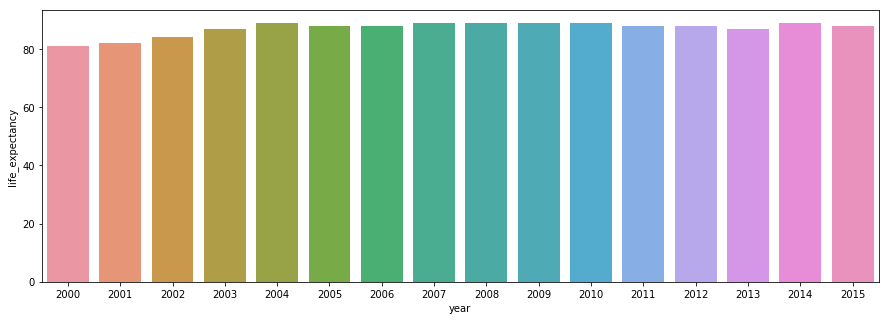

In [39]:
plt.figure(figsize=(15,5))
sns.barplot("year", "life_expectancy",data=df_max );

In [44]:
df.life_expectancy.max()

89.0

In [29]:
min_life=df.groupby("year").life_expectancy.idxmin()
df_min = df.loc[min_life]

for y in sorted(df.year.unique()):
    df_year = df[df.year == y]
    lowest_country = df_year.country[df_year.life_expectancy == df_year.life_expectancy.min()].values
    print(f"{y}: {lowest_country}")
    


2000: ['Sierra Leone']
2001: ['Sierra Leone']
2002: ['Malawi']
2003: ['Sierra Leone']
2004: ['Sierra Leone']
2005: ['Sierra Leone']
2006: ['Sierra Leone']
2007: ['Sierra Leone']
2008: ['Sierra Leone']
2009: ['Sierra Leone']
2010: ['Haiti']
2011: ['Sierra Leone']
2012: ['Sierra Leone']
2013: ['Central African Republic']
2014: ['Sierra Leone']
2015: ['Sierra Leone']


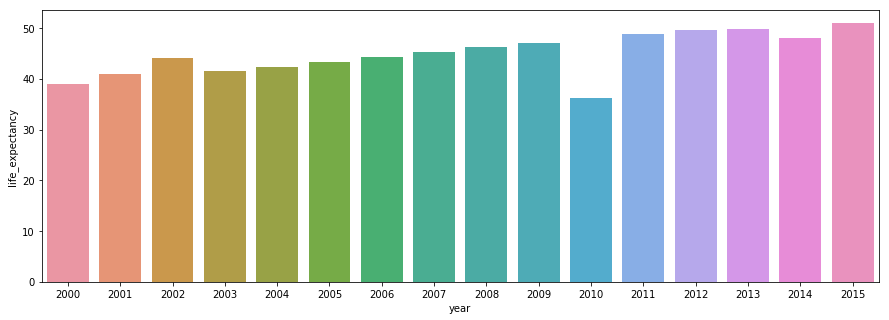

In [31]:
plt.figure(figsize=(15,5))
sns.barplot("year", "life_expectancy",data=df_min );

In [42]:
df.life_expectancy.min()

36.3

In [43]:
df[(df.life_expectancy == 36.3)]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
1127,Haiti,2010,Developing,36.3,682.0,23,5.76,36.292918,NaN,0,...,66.0,8.9,66.0,1.9,662.279518,9999617.0,4.0,4.0,0.47,8.6


In [46]:
df[(df.life_expectancy == 89)]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
241,Belgium,2014,Developed,89.0,76.0,0,12.60,7163.348923,98.0,70,...,99.0,1.59,99.0,0.1,47439.39684,112957.0,1.0,1.0,0.890,16.3
915,Finland,2014,Developing,89.0,78.0,0,8.80,6164.455402,NaN,0,...,98.0,9.68,98.0,0.1,49914.61864,5461512.0,0.9,0.8,0.890,17.0
937,France,2008,Developing,89.0,88.0,3,11.90,7002.785925,47.0,604,...,98.0,1.57,98.0,0.1,45413.65710,6437499.0,0.6,0.6,0.877,16.1
938,France,2007,Developing,89.0,89.0,3,12.20,64.737149,42.0,39,...,99.0,1.45,98.0,0.1,416.58397,6416229.0,0.6,0.6,0.873,16.1
995,Germany,2014,Developed,89.0,69.0,2,11.03,941.756291,88.0,443,...,94.0,11.30,95.0,0.1,4792.65288,89825.0,1.1,1.1,0.920,17.0
1293,Italy,2004,Developed,89.0,66.0,2,8.98,4270.914882,96.0,599,...,97.0,8.49,94.0,0.1,31174.56118,57685327.0,0.5,0.5,0.846,15.6
1850,New Zealand,2010,Developed,89.0,71.0,0,9.62,6664.148708,9.0,43,...,93.0,11.20,93.0,0.1,33691.34837,NaN,0.3,0.3,0.899,20.3
1916,Norway,2009,Developed,89.0,67.0,0,6.68,142.374943,NaN,2,...,94.0,9.49,94.0,0.1,817.77681,4828726.0,0.7,0.7,0.936,17.4
2056,Portugal,2014,Developed,89.0,78.0,0,9.88,271.254553,98.0,0,...,98.0,9.50,98.0,0.1,2277.53613,14162.0,0.7,0.5,0.837,16.8
2433,Spain,2007,Developed,89.0,72.0,2,11.05,510.932701,96.0,267,...,96.0,8.36,96.0,0.1,3279.41400,4522683.0,0.6,0.5,0.849,16.0


Bisa Dilihat perbedaan antara negara dengan angka harapan hidup tinggi dan rendah. kolom penting seperti HIV_AIDS, adult_mortality perbedaannya sangat besar. pada negara dengan life_expectancy tinggi, rerata nilai adut_mortalitynya sekitar 72 dan pada negara yang rendah nilainya hingga 682. sedangkan pada nilai HIV_AIDS nya 0.1 dan 1.9. kolom penting lainnya pun perbedaannya teramat sangat jauh.


Negara yang mendominasi nilai tertinggi dari angka harapan hidup berasal dari benua eropa, sedangkan yang mendominasi nilai terendah adalah benua afrika.

dari website:https://kumparan.com/trubus-id/meski-tak-merata-angka-harapan-hidup-orang-eropa-meningkat-1536942794712690434 , dijelaskan bahwa ada 4 aspek yang menjadi alasan kenapa di benua eropa angka harapan hidupnya tinggi:

1. Ilmu kedokteran yang maju  
2. Adanya pelayanan kesehatan yang baik bagi warga negara
3. Pengaturan akan polusi yang kuat
4. Kondisi yang damai tanpa adanya konflik dan tingkat kejahatan rendah

nyatanya memang negara eropa dari 4 aspek tersebut jauh lebih baik dari afrika.


# Angka Harapan Hidup Negara Indonesia

In [48]:
my_country_indonesia = df[df["country"] == "Indonesia"].sort_values("year")
my_country_indonesia

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
1217,Indonesia,2000,Developing,66.3,188.0,187,0.06,3.433344,65.0,3344,...,72.0,1.98,75.0,0.1,78.927440,21154429.0,11.0,11.2,0.597,10.7
1216,Indonesia,2001,Developing,66.5,188.0,182,0.06,33.958371,62.0,3825,...,77.0,2.23,76.0,0.1,747.981745,2145652.0,11.0,11.1,0.604,10.6
1215,Indonesia,2002,Developing,66.7,189.0,177,0.05,43.178673,63.0,14492,...,8.0,2.27,7.0,0.1,899.555686,2175859.0,11.0,11.1,0.608,10.6
1214,Indonesia,2003,Developing,66.9,189.0,173,0.05,8.460156,64.0,24457,...,8.0,2.53,71.0,0.1,164.594470,22545214.0,1.9,11.0,0.613,10.8
1213,Indonesia,2004,Developing,65.3,213.0,174,0.06,55.361072,64.0,29171,...,79.0,2.37,71.0,0.1,1148.569960,223614649.0,1.9,1.9,0.624,11.0
1212,Indonesia,2005,Developing,67.2,19.0,163,0.06,5.381783,65.0,15853,...,79.0,2.79,72.0,0.1,126.928834,22671273.0,1.9,1.9,0.629,11.1
1211,Indonesia,2006,Developing,67.3,191.0,159,0.06,72.015932,66.0,20422,...,78.0,2.91,72.0,0.1,1586.254000,22983822.0,1.8,1.8,0.632,10.9
1210,Indonesia,2007,Developing,67.5,19.0,154,0.06,102.633435,76.0,19456,...,77.0,3.10,73.0,0.2,1855.939150,232989141.0,1.8,1.7,0.638,11.0
1209,Indonesia,2008,Developing,67.7,189.0,149,0.07,10.263411,82.0,15369,...,83.0,2.81,77.0,0.2,216.527660,236159276.0,1.7,1.7,0.641,11.7
1208,Indonesia,2009,Developing,67.9,189.0,143,0.08,125.798068,82.0,20818,...,85.0,2.83,78.0,0.3,2254.445660,23934478.0,1.7,1.6,0.645,11.7


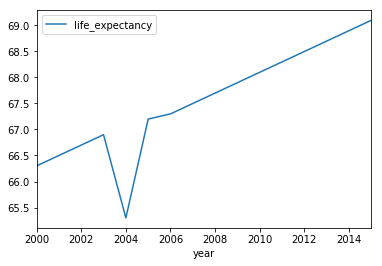

In [49]:
ahh_indo = df[df.country == 'Indonesia'].sort_values("year")
ahh_indo.plot('year', 'life_expectancy')

Sepertinya di tahun 2004 terdapat data yang salah input, mari kita cek google untuk melihat pastinya

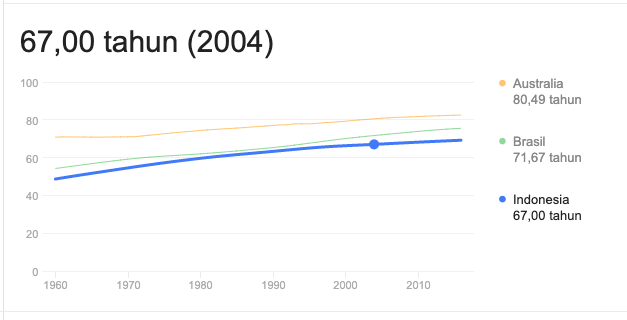

In [50]:
Image("z.png")

Setiap Tahunnya Indonesia mengalami kenaikan angka harapan hidup. dilihat dari datanya, rata-rata kenaikan angka harapan hidup sekitar 2%. pada tahun 2015, angka harapan hidup negara Indonesia sekitar 69,1. angka tersebut sudah diatas nilai normal, bisa dibilang angka harapan hidup indonesia tinggi.

# Faktor Lainnya

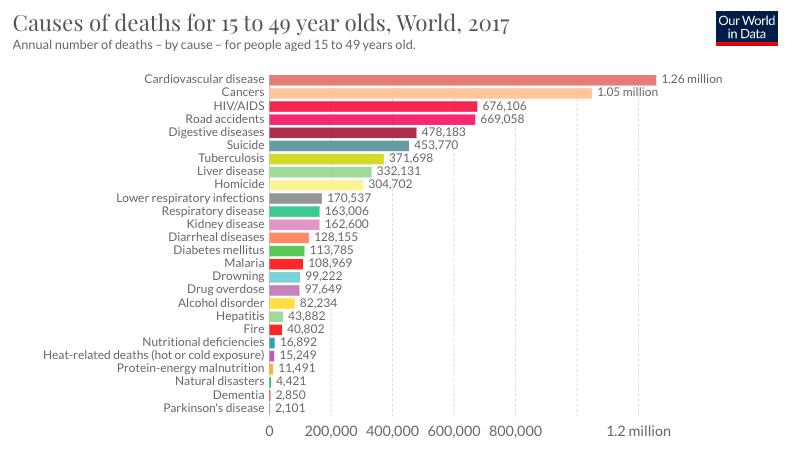

In [67]:
Image("a.png")


dilansir dari: https://ourworldindata.org/homicides, pada suatu negara rata2 1% nya merupakan salah satu dari data diatas, tapi terdapat beberapa negara yang warganya dengan usia 15 - 49 tahun nya meninggal diatas 10% dikarenakan hal diatas. dari data ini dapat disimpulkan bahwa angka harapan hidup juga dipengaruhi oleh pembunuhan, bunuh diri, dan memiliki suatu penyakit. 

yang saya tekankan disini adalah tingkat bunuh diri dan pembunuhan. karena tingkat bunuh diri dan pembunuhan banyak terjadi pada orang yang berumur 10-40 tahun. mari kita ulas tingkat bunuh diri dan pembunuhan suatu negara

### Bunuh Diri

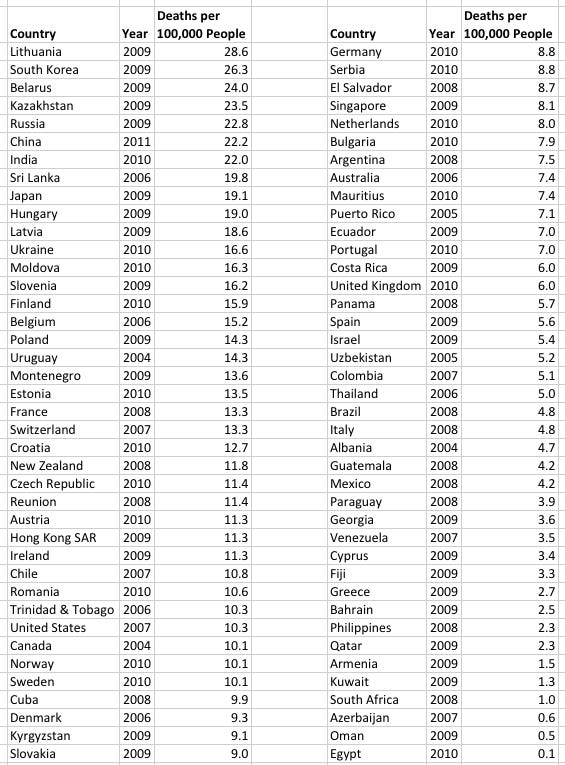

In [68]:
Image('b.jpeg')



dilansir dari https://www.businessinsider.com/world-suicide-rate-map-2014-4?IR=T, dan https://www.who.int/mental_health/prevention/suicide/suicideprevent/en/ angka bunuh diri dari seluruh negara yang ada didunia totalnya adalah 222.093 dan yang melakukan adalah orang yang berumur kisaran 10-29 tahun. jika nilai bunuh diri ini terus meningkat, bisa-bisa negara seperti lithuania, korea selatan dan lainnya akan memiliki angka harapan hidup hanya sampai 29 tahun. oleh karena itu, angka bunuh diri juga harus diperhitungkan.

### Pembunuhan

In [69]:
dd = pd.read_csv('d.csv')
dd.head()

,name,homicideRate,pop2019
0,El Salvador,82.8423,6453.553
1,Honduras,56.5157,9746.117
2,United States Virgin Islands,49.2625,104.578
3,Jamaica,47.0111,2948.279
4,Lesotho,41.2481,2125.268



dilansir dari: http://worldpopulationreview.com/countries/murder-rate-by-country/ , tingkat pembunuhan bahkan lebih besar dari tingkat bunuh diri. nilai tertinggi dari bunuh diri sekitar 29 / 100.000 orang, sedangkan tingkat pembunuhan tertinggi adalah 83 / 100.000 orang. 

walaupun angka pembunuhan lebih besar dari bunuh diri, menurut saya bunuh diri lebih membahayakan dari pembunuhan. kenapa? karena pembunuhan dilakukan oleh orang lain, kita bisa menyelidiki dan masih ada kemungkinan untuk mengetahui siapa pelakunya dan dapat menindak lanjuti pelaku tersebut hingga pelaku pembunuhan jera.
sedangkan kalau bunuh diri, seseorang dapat bunuh diri dimanapun dan kapanpun tanpa mengenal tempat dan waktu

# Memprediksi dengan Algoritma Machine Learning XGBOOST

In [11]:
X = df.drop(columns="life_expectancy")
y = df.life_expectancy

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2342, 21), (586, 21), (2342,), (586,))

In [73]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['year', 'adult_mortality', 'infant_deaths',
                               'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
                               'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
                               'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']),
    ('categoric', cat_pipe(encoder='onehot'), ["country","status"])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   29.9s finished


{'algo__colsample_bytree': 0.7545447962707789, 'algo__gamma': 8, 'algo__learning_rate': 0.13832094546570484, 'algo__max_depth': 9, 'algo__n_estimators': 161, 'algo__reg_alpha': 0.02001342062287998, 'algo__reg_lambda': 0.035868164986275514, 'algo__subsample': 0.43567451588694794}
0.9930267677205243 0.9574825425799804 0.9671654448450613


# Save Model

In [74]:
save_model(model.best_estimator_, 'xgb_life_expectancy.pkl')

Model is pickled as model/xgb_life_expectancy.pkl


# Load Model

In [13]:
model = load_model("model/xgb_life_expectancy.pkl")

In [78]:
model.predict(X_train)

array([75.352776, 71.91917 , 56.098072, ..., 63.363235, 79.75081 ,
       58.714066], dtype=float32)

In [79]:
model.predict(X_test)

array([55.725677, 71.49462 , 82.946846, 75.73642 , 54.577854, 63.443573,
       73.44979 , 74.40164 , 76.00117 , 67.08933 , 74.88635 , 74.47116 ,
       44.574085, 48.096012, 74.17809 , 75.328156, 78.88516 , 78.26908 ,
       77.34708 , 73.282845, 60.776264, 82.37311 , 50.398888, 62.15414 ,
       69.48202 , 46.48958 , 53.268112, 75.102615, 67.01302 , 78.896194,
       73.199715, 74.49654 , 63.48825 , 70.6598  , 72.91787 , 58.651215,
       74.80227 , 69.94733 , 77.474945, 73.428055, 60.43247 , 66.41265 ,
       80.11992 , 56.083206, 50.426025, 68.43908 , 78.02609 , 67.94244 ,
       64.28209 , 61.230957, 72.43059 , 72.51758 , 65.976166, 57.378456,
       67.27638 , 71.97502 , 70.2141  , 73.20225 , 75.35852 , 55.198837,
       73.41794 , 70.53841 , 62.657482, 51.495964, 52.824223, 83.45195 ,
       63.418865, 55.497208, 75.14024 , 73.41661 , 74.849365, 80.92412 ,
       74.157104, 74.89018 , 52.564785, 74.3467  , 75.07662 , 75.13192 ,
       74.01606 , 75.55878 , 74.817345, 78.72212 , 

/Users/farhan/opt/miniconda3/envs/jcopml/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


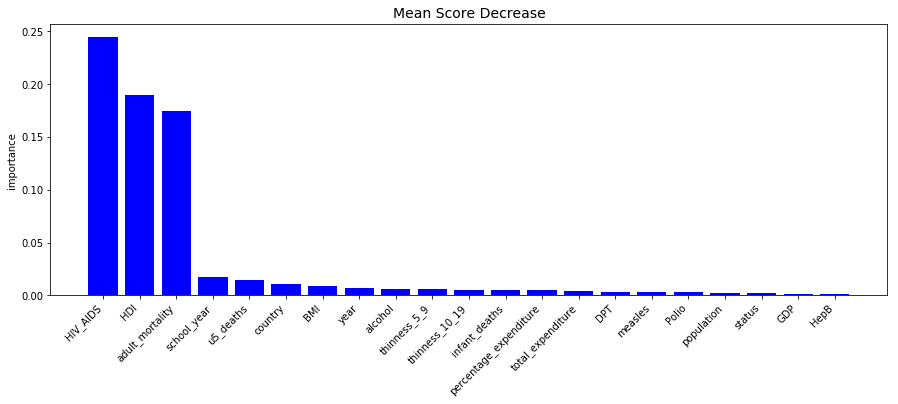

In [14]:
df.imp = mean_score_decrease(X_train, y_train, model, plot=True)